# Basic Text Classification with Naive Bayes
***
In the mini-project, you'll learn the basics of text analysis using a subset of movie reviews from the rotten tomatoes database. You'll also use a fundamental technique in Bayesian inference, called Naive Bayes. This mini-project is based on [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class.  Please free to go to the original lab for additional exercises and solutions.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

# Table of Contents

* [Rotten Tomatoes Dataset](#Rotten-Tomatoes-Dataset)
    * [Explore](#Explore)
* [The Vector Space Model and a Search Engine](#The-Vector-Space-Model-and-a-Search-Engine)
    * [In Code](#In-Code)
* [Naive Bayes](#Naive-Bayes)
    * [Multinomial Naive Bayes and Other Likelihood Functions](#Multinomial-Naive-Bayes-and-Other-Likelihood-Functions)
    * [Picking Hyperparameters for Naive Bayes and Text Maintenance](#Picking-Hyperparameters-for-Naive-Bayes-and-Text-Maintenance)
* [Interpretation](#Interpretation)


## Rotten Tomatoes Dataset

In [2]:
critics = pd.read_csv('./critics.csv')
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


### Explore

In [3]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size


print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


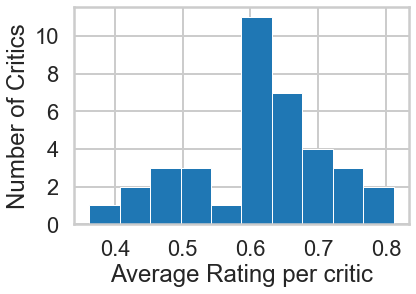

In [4]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);

<div class="span5 alert alert-info">
<h3>Exercise Set I</h3>
<br/>
<b>Exercise:</b> Look at the histogram above. Tell a story about the average ratings per critic. What shape does the distribution look like? What is interesting about the distribution? What might explain these interesting things?
</div>

This histogram maps the rate at which critics who left more than a hundred reviews rated films as "fresh" (as opposed to "rotten"). It almost appears to be normally distributed, but perhaps with some missing data between 0.5 and 0.6 on the x axis. Because of this gap, we can say that it has bimodal distribution, with one peak just above 0.6 (majority positive ratings) and another just below 0.5 (majority-ish negative ratings). It appears that mean is around 0.6-0.7, meaning that many critics rated films as fresh 60-70% of the time (in other words, 60-70% of all the films they rated were rated as fresh). No critic rated more than 80% of films they saw as positive, and no critic rated less than ~35% percent of all films they saw as negative. In general, critics tended to give more positive reviews than negative reviews. The bimodality of the histogram might be explained by the binary classification in the rating system (only rotten or fresh), so there's not much room for nuance for neutral opinions. And in this chart the ~0.5 range represents the rate of positive opinions anyway. On average it seems that reviewers have good opinions about movies (or they are generous!).

## The Vector Space Model and a Search Engine

All the diagrams here are snipped from [*Introduction to Information Retrieval* by Manning et. al.]( http://nlp.stanford.edu/IR-book/) which is a great resource on text processing. For additional information on text mining and natural language processing, see [*Foundations of Statistical Natural Language Processing* by Manning and Schutze](http://nlp.stanford.edu/fsnlp/).

Also check out Python packages [`nltk`](http://www.nltk.org/), [`spaCy`](https://spacy.io/), [`pattern`](http://www.clips.ua.ac.be/pattern), and their associated resources. Also see [`word2vec`](https://en.wikipedia.org/wiki/Word2vec).

Let us define the vector derived from document $d$ by $\bar V(d)$. What does this mean? Each document is treated as a vector containing information about the words contained in it. Each vector has the same length and each entry "slot" in the vector contains some kind of data about the words that appear in the document such as presence/absence (1/0), count (an integer) or some other statistic. Each vector has the same length because each document shared the same vocabulary across the full collection of documents -- this collection is called a *corpus*.

To define the vocabulary, we take a union of all words we have seen in all documents. We then just associate an array index with them. So "hello" may be at index 5 and "world" at index 99.

Suppose we have the following corpus:

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree. The grapes seemed ready to burst with juice, and the Fox's mouth watered as he gazed longingly at them.`

Suppose we treat each sentence as a document $d$. The vocabulary (often called the *lexicon*) is the following:

$V = \left\{\right.$ `a, along, and, as, at, beautiful, branches, bunch, burst, day, fox, fox's, from, gazed, grapes, hanging, he, juice, longingly, mouth, of, one, ready, ripe, seemed, spied, the, them, to, trained, tree, vine, watered, with`$\left.\right\}$

Then the document

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree`

may be represented as the following sparse vector of word counts:

$$\bar V(d) = \left( 4,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,2,1,0,1,0,0,1,0,0,1,1,1,0,0 \right)$$

or more succinctly as

`[(0, 4), (1, 1), (5, 1), (6, 1), (7, 1), (9, 1), (10, 1), (12, 1), (14, 1), (15, 1), (20, 2), (21, 1), (23, 1),`
`(26, 1), (29,1), (30, 1), (31, 1)]`

along with a dictionary

``
{
    0: a, 1: along, 5: beautiful, 6: branches, 7: bunch, 9: day, 10: fox, 12: from, 14: grapes, 15: hanging, 19: mouth, 20: of, 21: one, 23: ripe, 24: seemed, 25: spied, 26: the, 29:trained, 30: tree, 31: vine, 
}
``

Then, a set of documents becomes, in the usual `sklearn` style, a sparse matrix with rows being sparse arrays representing documents and columns representing the features/words in the vocabulary.

Notice that this representation loses the relative ordering of the terms in the document. That is "cat ate rat" and "rat ate cat" are the same. Thus, this representation is also known as the Bag-Of-Words representation.

Here is another example, from the book quoted above, although the matrix is transposed here so that documents are columns:

![novel terms](terms.png)

Such a matrix is also catted a Term-Document Matrix. Here, the terms being indexed could be stemmed before indexing; for instance, `jealous` and `jealousy` after stemming are the same feature. One could also make use of other "Natural Language Processing" transformations in constructing the vocabulary. We could use Lemmatization, which reduces words to lemmas: work, working, worked would all reduce to work. We could remove "stopwords" from our vocabulary, such as common words like "the". We could look for particular parts of speech, such as adjectives. This is often done in Sentiment Analysis. And so on. It all depends on our application.

From the book:
>The standard way of quantifying the similarity between two documents $d_1$ and $d_2$  is to compute the cosine similarity of their vector representations $\bar V(d_1)$ and $\bar V(d_2)$:

$$S_{12} = \frac{\bar V(d_1) \cdot \bar V(d_2)}{|\bar V(d_1)| \times |\bar V(d_2)|}$$

![Vector Space Model](vsm.png)


>There is a far more compelling reason to represent documents as vectors: we can also view a query as a vector. Consider the query q = jealous gossip. This query turns into the unit vector $\bar V(q)$ = (0, 0.707, 0.707) on the three coordinates below. 

![novel terms](terms2.png)

>The key idea now: to assign to each document d a score equal to the dot product:

$$\bar V(q) \cdot \bar V(d)$$

Then we can use this simple Vector Model as a Search engine.

### In Code

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
['hop', 'off', 'on', 'pop']


In [6]:
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
X, y = make_xy(critics)

## Naive Bayes

From Bayes' Theorem, we have that

$$P(c \vert f) = \frac{P(c \cap f)}{P(f)}$$

where $c$ represents a *class* or category, and $f$ represents a feature vector, such as $\bar V(d)$ as above. **We are computing the probability that a document (or whatever we are classifying) belongs to category *c* given the features in the document.** $P(f)$ is really just a normalization constant, so the literature usually writes Bayes' Theorem in context of Naive Bayes as

$$P(c \vert f) \propto P(f \vert c) P(c) $$

$P(c)$ is called the *prior* and is simply the probability of seeing class $c$. But what is $P(f \vert c)$? This is the probability that we see feature set $f$ given that this document is actually in class $c$. This is called the *likelihood* and comes from the data. One of the major assumptions of the Naive Bayes model is that the features are *conditionally independent* given the class. While the presence of a particular discriminative word may uniquely identify the document as being part of class $c$ and thus violate general feature independence, conditional independence means that the presence of that term is independent of all the other words that appear *within that class*. This is a very important distinction. Recall that if two events are independent, then:

$$P(A \cap B) = P(A) \cdot P(B)$$

Thus, conditional independence implies

$$P(f \vert c)  = \prod_i P(f_i | c) $$

where $f_i$ is an individual feature (a word in this example).

To make a classification, we then choose the class $c$ such that $P(c \vert f)$ is maximal.

There is a small caveat when computing these probabilities. For [floating point underflow](http://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html) we change the product into a sum by going into log space. This is called the LogSumExp trick. So:

$$\log P(f \vert c)  = \sum_i \log P(f_i \vert c) $$

There is another caveat. What if we see a term that didn't exist in the training data? This means that $P(f_i \vert c) = 0$ for that term, and thus $P(f \vert c)  = \prod_i P(f_i | c) = 0$, which doesn't help us at all. Instead of using zeros, we add a small negligible value called $\alpha$ to each count. This is called Laplace Smoothing.

$$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$

where $N_{ic}$ is the number of times feature $i$ was seen in class $c$, $N_c$ is the number of times class $c$ was seen and $N_i$ is the number of times feature $i$ was seen globally. $\alpha$ is sometimes called a regularization parameter.

### Multinomial Naive Bayes and Other Likelihood Functions

Since we are modeling word counts, we are using variation of Naive Bayes called Multinomial Naive Bayes. This is because the likelihood function actually takes the form of the multinomial distribution.

$$P(f \vert c) = \frac{\left( \sum_i f_i \right)!}{\prod_i f_i!} \prod_{f_i} P(f_i \vert c)^{f_i} \propto \prod_{i} P(f_i \vert c)$$

where the nasty term out front is absorbed as a normalization constant such that probabilities sum to 1.

There are many other variations of Naive Bayes, all which depend on what type of value $f_i$ takes. If $f_i$ is continuous, we may be able to use *Gaussian Naive Bayes*. First compute the mean and variance for each class $c$. Then the likelihood, $P(f \vert c)$ is given as follows

$$P(f_i = v \vert c) = \frac{1}{\sqrt{2\pi \sigma^2_c}} e^{- \frac{\left( v - \mu_c \right)^2}{2 \sigma^2_c}}$$

<div class="span5 alert alert-info">
<h3>Exercise Set II</h3>

<p><b>Exercise:</b> Implement a simple Naive Bayes classifier:</p>

<ol>
<li> split the data set into a training and test set
<li> Use `scikit-learn`'s `MultinomialNB()` classifier with default parameters.
<li> train the classifier over the training set and test on the test set
<li> print the accuracy scores for both the training and the test sets
</ol>

What do you notice? Is this a good classifier? If not, why not?
</div>

In [7]:
#your turn

#imports
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score

#train-test split of text vectors (X) and tags (y) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#instantiate Naive Bayes classifier, default parameters are: alpha=1.0, fit_prior=True, class_prior=None
NBclassifier = MultinomialNB()

#fit classifier with the training data
NBclassifier.fit(X_train, y_train)

#print accuracy score for training
train_accuracy = NBclassifier.score(X_train, y_train)

#check on the test set and print accuracy score
test_accuracy = NBclassifier.score(X_test, y_test)

print("Training set score is {}".format(train_accuracy))
print("Test set score is {}".format(test_accuracy))

Training set score is 0.9202281491002571
Test set score is 0.7889495663347253


Summary: This model performed well on the training set, with about a 92% accuracy rate. It performed less well on the test set, with an accuracy rate of only about 79%. Still, this was better than I expected, given that no parameters were tuned and no text pre-processing had been done.

### Picking Hyperparameters for Naive Bayes and Text Maintenance

We need to know what value to use for $\alpha$, and we also need to know which words to include in the vocabulary. As mentioned earlier, some words are obvious stopwords. Other words appear so infrequently that they serve as noise, and other words in addition to stopwords appear so frequently that they may also serve as noise.

First, let's find an appropriate value for `min_df` for the `CountVectorizer`. `min_df` can be either an integer or a float/decimal. If it is an integer, `min_df` represents the minimum number of documents a word must appear in for it to be included in the vocabulary. If it is a float, it represents the minimum *percentage* of documents a word must appear in to be included in the vocabulary. From the documentation:

>min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

<div class="span5 alert alert-info">
<h3>Exercise Set III</h3>

<p><b>Exercise:</b> Construct the cumulative distribution of document frequencies (df). The $x$-axis is a document count $x_i$ and the $y$-axis is the percentage of words that appear less than $x_i$ times. For example, at $x=5$, plot a point representing the percentage or number of words that appear in 5 or fewer documents.</p>

<p><b>Exercise:</b> Look for the point at which the curve begins climbing steeply. This may be a good value for `min_df`. If we were interested in also picking `max_df`, we would likely pick the value where the curve starts to plateau. What value did you choose?</p>
</div>

In [8]:
# Your turn.

#convert word vectors into DF
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(critics.quote)
vector_df = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())

vector_df.head()

,000,0014,007,044,07,10,100,101,102,104,105,108,10th,11,110,112,1138,114,118,11th,12,124,125,128,13,130,131,132,133,134,136,137,13th,14,141,145,15,153,15th,16,160,161,1660s,16mm,16th,17,17th,18,180,185,...,zellweger,zemeckis,zen,zero,zeroes,zest,zestfully,zesty,zeta,zhang,zhivago,ziggurats,zigs,zigzag,zigzags,zillion,zimmer,zing,zinger,zingers,zings,zingy,zinnemann,zinner,zip,zipper,zippo,zippy,zips,zirconium,zoe,zombie,zombies,zombified,zonca,zone,zoning,zoo,zoological,zoom,zooming,zooms,zorro,zorros,zowie,zucker,zweibel,zwick,zzzzzs,zzzzzzzzz
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
#sum all of the columns
sums = vector_df.sum(axis=0)
sums.head()

000      8
0014     1
007     10
044      1
07       1
dtype: int64

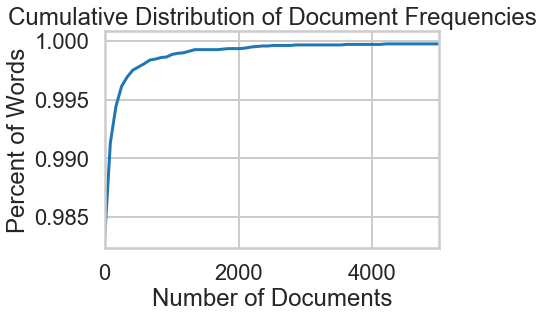

In [10]:
#create plot of cumulative sums
hist, bins = np.histogram(sums, bins=200)

cumulative = np.cumsum(hist)
cumulativePercent = cumulative/cumulative[-1]

plt.plot(bins[:-1], cumulativePercent)
plt.xlim(-1, 5000)
plt.title('Cumulative Distribution of Document Frequencies')
plt.xlabel('Number of Documents')
plt.ylabel('Percent of Words')
plt.show()

Summary: The curve is already climbing steeply from the beginning. To reflect this, we can choose a very low min_df, such as min_df = 1. For max_df, this is not as easy to tell without adjusting the xlim further. We can perhaps chose a max_df around 100-200.

The parameter $\alpha$ is chosen to be a small value that simply avoids having zeros in the probability computations. This value can sometimes be chosen arbitrarily with domain expertise, but we will use K-fold cross validation. In K-fold cross-validation, we divide the data into $K$ non-overlapping parts. We train on $K-1$ of the folds and test on the remaining fold. We then iterate, so that each fold serves as the test fold exactly once. The function `cv_score` performs the K-fold cross-validation algorithm for us, but we need to pass a function that measures the performance of the algorithm on each fold. 

In [11]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

We use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

The custom scoring function `scorefunc` allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as the scoring function.

In [12]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

We'll cross-validate over the regularization parameter $\alpha$.

Let's set up the train and test masks first, and then we can run the cross-validation procedure.

In [13]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

<div class="span5 alert alert-info">
<h3>Exercise Set IV</h3>

<p><b>Exercise:</b> What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?</p>

<p><b>Exercise:</b> Without writing any code, what do you think would happen if you choose a value of $\alpha$ that is too high?</p>

<p><b>Exercise:</b> Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.</p>
</div>

In [14]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
min_dfs = [0.1, 1, 5] # YOUR TURN: put your value of min_df here.

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
best_min_df = 1
for alpha in alphas: 
    for min_df in min_dfs:
        vectorizer = CountVectorizer(min_df=best_min_df) #random_seed=0      
        Xthis, ythis = make_xy(critics, vectorizer)
        Xtrainthis = Xthis[mask]
        ytrainthis = ythis[mask]
    # your turn
        classifier = MultinomialNB(alpha=alpha)
        score = cv_score(classifier, Xtrainthis, ytrainthis, log_likelihood)
        if score > maxscore:
            maxscore = score
            best_alpha = alpha
            best_min_df = min_df

In [15]:
print("alpha: {}".format(best_alpha))
print("min_df: {}".format(best_min_df))
print("maxscore: {}".format(maxscore))

alpha: 0.1
min_df: 1
maxscore: -622.9358462829198


Summary: Using the log_likelihood function produces the best maximum likelihood estimates (MLEs) parameters of a particular kind of distribution, in this case the log normal distribution, shown from the cumulative distribution plot. In Naive Bayes, alpha is a smoothing parameter which, as it increases, increases the probability that words not in the sentence can be accounted for. In other words, it adds value to the predictor words from the testing that may not have been present in the training data. Without the additive smoothing from alpha, these predictors will automatically have a frequency of 0 from training, so they could negatively impact the classification results.


<div class="span5 alert alert-info">
<h3>Exercise Set V: Working with the Best Parameters</h3>

<p><b>Exercise:</b> Using the best value of  `alpha` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?</p>

</div>

In [16]:
vectorizer = CountVectorizer(min_df=1)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=0.1).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.973013
Accuracy on test data:     0.720804


In [17]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf.predict(xtest)))

[[2680 1564]
 [1477 5171]]


Summary: This classifier performs better on the training set than the one with the default values, but it performs worse on the test data. I suspect there may be overfitting. 

## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [18]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
               among 1.00
             delight 0.99
              thanks 0.99
         imaginative 0.99
            touching 0.99
              highly 0.99
               enjoy 0.99
              superb 0.99
            reminder 0.99
          mainstream 0.99
Bad words	     P(fresh | word)
          mechanical 0.01
                limp 0.01
             unfunny 0.01
         forgettable 0.01
            attempts 0.01
           pointless 0.01
                 buy 0.01
          uninspired 0.01
                lame 0.01
               bland 0.01


<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Why does this method work? What does the probability for each row in the identity matrix represent</p>

</div>

This table shows the probably of words appearing in a "fresh" review. The good words are words that are extremely likely to be in the fresh review, and the bad words are ones that are extremely unlikely. The good words are strongly predictive of a positive review.

The above exercise is an example of *feature selection*. There are many other feature selection methods. A list of feature selection methods available in `sklearn` is [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ [method](http://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).

### Prediction Errors

We can see mis-predictions as well.

In [19]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
The fact that so much money was lavished on such a thick-headed project represents the height of fiscal ineptitude, but this is the kind of roller-coaster ride for which eager audiences will gladly check their brains at the turnstiles, so go figure.

Director Ron Howard brings a quality of gentleness and whimsy to the performances, but basically this is a highly calculated project brought in by those two old pros, producers Richard Zanuck and David Brown.

The title changes, the actors change, and the superficial details of the story change, but it is always about exactly the same thing: heavily armed men shooting at one another.

Scriptwriters Lowell Ganz and Babaloo Mandel neglect the ensemble, emphasising a sense of historical occasion over character development.

It's probably safe to say that the British director Peter Greenaway holds the ugliest view of mankind ever put forth by a maker of feature films.

Mis-predicted Fresh

<div class="span5 alert alert-info">
<h3>Exercise Set VII: Predicting the Freshness for a New Review</h3>
<br/>
<div>
<b>Exercise:</b>
<ul>
<li> Using your best trained classifier, predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*
<li> Is the result what you'd expect? Why (not)?
</ul>
</div>
</div>

In [20]:
#your turn
print(clf.predict(vectorizer.transform(['This movie is not remarkable, touching, or superb in any way'])))
print(clf.predict_proba(vectorizer.transform(['This movie is not remarkable, touching, or superb in any way'])))

[1]
[[3.67886196e-06 9.99996321e-01]]


Although this is a very negative review, the model predicts the class as 1, meaning it predicts this as a "fresh" review. The second array generated from predict_proba shows the probabilities of it being classed as 0 or 1, and here we see that it predicts an extremely low probability of this falling into class 0. 

Here we can see a potential pitfall of the BoW approach. This sentence contains words that are highly indicative of freshness, but it could not account for the negation.

### Aside: TF-IDF Weighting for Term Importance

TF-IDF stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weight this term frequency by the inverse of its popularity in all documents. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. It could actually be considered a stopword. By weighing its counts by 1 divided by its overall frequency, we downweight it. We can then use this TF-IDF weighted features as inputs to any classifier. **TF-IDF is essentially a measure of term importance, and of how discriminative a word is in a corpus.** There are a variety of nuances involved in computing TF-IDF, mainly involving where to add the smoothing term to avoid division by 0, or log of 0 errors. The formula for TF-IDF in `scikit-learn` differs from that of most textbooks: 

$$\mbox{TF-IDF}(t, d) = \mbox{TF}(t, d)\times \mbox{IDF}(t) = n_{td} \log{\left( \frac{\vert D \vert}{\vert d : t \in d \vert} + 1 \right)}$$

where $n_{td}$ is the number of times term $t$ occurs in document $d$, $\vert D \vert$ is the number of documents, and $\vert d : t \in d \vert$ is the number of documents that contain $t$

In [21]:
# http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
# http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(critics.quote)

<div class="span5 alert alert-info">
<h3>Exercise Set VIII: Enrichment <b>(Optional)</b></h3>

<p>
There are several additional things we could try. Try some of these as exercises:
<ol>
<li> Build a Naive Bayes model where the features are n-grams instead of words. N-grams are phrases containing n words next to each other: a bigram contains 2 words, a trigram contains 3 words, and 6-gram contains 6 words. This is useful because "not good" and "so good" mean very different things. On the other hand, as n increases, the model does not scale well since the feature set becomes more sparse.
<li> Try a model besides Naive Bayes, one that would allow for interactions between words -- for example, a Random Forest classifier.
<li> Try adding supplemental features -- information about genre, director, cast, etc.
<li> Use word2vec or [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to group words into topics and use those topics for prediction.
<li> Use TF-IDF weighting instead of word counts.
</ol>
</p>

<b>Exercise:</b> Try at least one of these ideas to improve the model (or any other ideas of your own). Implement here and report on the result. 
</div>

In [22]:
# Your turn

#NB model with TF-IDF weighting, default parameters


Xtfidf = Xtfidf.tocsc()  # some versions of sklearn return COO format
ytfidf = (critics.fresh == 'fresh').values.astype(np.int)
    
    #train-test split of text vectors (X) and tags (y) 
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(Xtfidf, ytfidf, test_size=0.2, random_state=42)

#instantiate Naive Bayes classifier, default parameters are: alpha=1.0, fit_prior=True, class_prior=None
NBclassifierTFIDF = MultinomialNB()

#fit classifier with the training data
clfTFIDF = NBclassifierTFIDF.fit(X_train_tf, y_train_tf)

#print accuracy score for training
train_accuracy = clfTFIDF.score(X_train_tf, y_train_tf)

#check on the test set and print accuracy score
test_accuracy = clfTFIDF.score(X_test_tf, y_test_tf)

print("Training set score is {}".format(train_accuracy))
print("Test set score is {}".format(test_accuracy))

Training set score is 0.8447140102827764
Test set score is 0.7243816254416962


In [23]:
print(clfTFIDF.predict(tfidfvectorizer.transform(['This movie is not remarkable, touching, or superb in any way'])))
print(clfTFIDF.predict_proba(tfidfvectorizer.transform(['This movie is not remarkable, touching, or superb in any way'])))

[1]
[[0.02198674 0.97801326]]


The score is worse for both the training data and the test data than with the regular weighting. It also makes an incorrect prediction for the edge case test sentence. The probability of it being classed as 0 is very low (2%).

In [24]:
#NB model with bigrams instead of unigrams

_, itest = train_test_split(range(critics.shape[0]), train_size=0.8)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

#the grid of parameters to search over
alphas = [0.01, 0.1, 1, 5, 10, 50]
min_dfs = [0.01, 0.1, 1, 5] # YOUR TURN: put your value of min_df here.

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
best_min_df = 1
for alpha in alphas: 
    for min_df in min_dfs:
        vectorizer = CountVectorizer(min_df=best_min_df, ngram_range=(2, 2)) #random_seed=0      
        Xthis, ythis = make_xy(critics, vectorizer)
        Xtrainthis = Xthis[mask]
        ytrainthis = ythis[mask]
    # your turn
        classifier = MultinomialNB(alpha=alpha)
        score = cv_score(classifier, Xtrainthis, ytrainthis, log_likelihood)
        if score > maxscore:
            maxscore = score
            best_alpha = alpha
            best_min_df = min_df

print("alpha: {}".format(best_alpha))
print("min_df: {}".format(best_min_df))
print("maxscore: {}".format(maxscore))


ngram_vect = CountVectorizer(min_df = best_min_df, ngram_range=(2, 2))
Xngram = vectorizer.fit_transform(critics.quote)
Xngram = Xngram.tocsc()  # some versions of sklearn return COO format
yngram = (critics.fresh == 'fresh').values.astype(np.int)

#train-test split of text vectors (X) and tags (y) 
X_train_ngram, X_test_ngram, y_train_ngram, y_test_ngram = train_test_split(Xngram, yngram, test_size=0.2, random_state=42)

#instantiate Naive Bayes classifier, default parameters are: alpha=1.0, fit_prior=True, class_prior=None
NBclassifierNGram = MultinomialNB(alpha=best_alpha)

#fit classifier with the training data
clfNGram = NBclassifierNGram.fit(X_train_ngram, y_train_ngram)

#print accuracy score for training
train_accuracy = clfNGram.score(X_train_ngram, y_train_ngram)

#check on the test set and print accuracy score
test_accuracy = clfNGram.score(X_test_ngram, y_test_ngram)

print("Training set score is {}".format(train_accuracy))
print("Test set score is {}".format(test_accuracy))

alpha: 0.01
min_df: 0.1
maxscore: -415.4374527366551
Training set score is 0.6087724935732648
Test set score is 0.6116286540314809


In [25]:
print(clfNGram.predict(vectorizer.transform(['This movie is not remarkable, touching, or superb in any way'])))
print(clfNGram.predict_proba(vectorizer.transform(['This movie is not remarkable, touching, or superb in any way'])))

[1]
[[0.39122751 0.60877249]]


The bigram model performs worse overall on new data, and the prediction for the edge case is also still incorrect. However, it is more probable that it will predict the right classification (39% chance of 0).

In [26]:
#Random forest classifier with default parameters



from sklearn.ensemble import RandomForestClassifier

vectRF = CountVectorizer()
XRF = vectorizer.fit_transform(critics.quote)
XRF = XRF.tocsc()  # some versions of sklearn return COO format
yRF = (critics.fresh == 'fresh').values.astype(np.int)

#train-test split of text vectors (X) and tags (y) 
X_train_RF, X_test_RF, y_train_RF, y_test_RF = train_test_split(XRF, yRF, test_size=0.2, random_state=42)

#instantiate Naive Bayes classifier, default parameters are: alpha=1.0, fit_prior=True, class_prior=None
RFclassifier = RandomForestClassifier()

#fit classifier with the training data
clfRF = RFclassifier.fit(X_train_RF, y_train_RF)

#print accuracy score for training
train_accuracy = clfRF.score(X_train_RF, y_train_RF)

#check on the test set and print accuracy score
test_accuracy = clfRF.score(X_test_RF, y_test_RF)

print("Training set score is {}".format(train_accuracy))
print("Test set score is {}".format(test_accuracy))

Training set score is 0.6087724935732648
Test set score is 0.6116286540314809


/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [27]:
print(clfRF.predict(vectorizer.transform(['This movie is not remarkable, touching, or superb in any way'])))
print(clfRF.predict_proba(vectorizer.transform(['This movie is not remarkable, touching, or superb in any way'])))

[1]
[[0.40016349 0.59983651]]


The random forest model might be overfit with the training data, and is still worse than the default NB model for the new data. However, the probability of making the right prediction for the edge case still better than before (40%).

In [28]:
#randomforest with bigrams

vectRFbigram = CountVectorizer(ngram_range=(2, 2))
XRFbigram = vectorizer.fit_transform(critics.quote)
XRFbigram = XRF.tocsc()  # some versions of sklearn return COO format
yRFbigram = (critics.fresh == 'fresh').values.astype(np.int)

#train-test split of text vectors (X) and tags (y) 
X_train_RFbigram, X_test_RFbigram, y_train_RFbigram, y_test_RFbigram = train_test_split(XRFbigram, 
                                                                                        yRFbigram, 
                                                                                        test_size=0.2, 
                                                                                        random_state=42)

#instantiate Naive Bayes classifier, default parameters are: alpha=1.0, fit_prior=True, class_prior=None
RFclassifierBigram = RandomForestClassifier()

#fit classifier with the training data
clfRFbigram = RFclassifierBigram.fit(X_train_RFbigram, y_train_RFbigram)

#print accuracy score for training
train_accuracy = clfRFbigram.score(X_train_RFbigram, y_train_RFbigram)

#check on the test set and print accuracy score
test_accuracy = clfRFbigram.score(X_test_RFbigram, y_test_RFbigram)

print("Training set score is {}".format(train_accuracy))
print("Test set score is {}".format(test_accuracy))

Training set score is 0.6087724935732648
Test set score is 0.6116286540314809


/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [29]:
print(clfRFbigram.predict(vectorizer.transform(['This movie is not remarkable, touching, or superb in any way'])))
print(clfRFbigram.predict_proba(vectorizer.transform(['This movie is not remarkable, touching, or superb in any way'])))

[1]
[[0.3955992 0.6044008]]


In [30]:
#Random Forest with TF-IDF weighting in word vectors

#split this way above:
#X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(Xtfidf, ytfidf, test_size=0.2, random_state=42)

#instantiate Naive Bayes classifier, default parameters are: alpha=1.0, fit_prior=True, class_prior=None
RFclassifierTFIDF = RandomForestClassifier()

#fit classifier with the training data
RFclfTFIDF = RFclassifierTFIDF.fit(X_train_tf, y_train_tf)

#print accuracy score for training
train_accuracy = RFclfTFIDF.score(X_train_tf, y_train_tf)

#check on the test set and print accuracy score
test_accuracy = RFclfTFIDF.score(X_test_tf, y_test_tf)

print("Training set score is {}".format(train_accuracy))
print("Test set score is {}".format(test_accuracy))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training set score is 0.9872268637532133
Test set score is 0.7096048827497591


In [31]:
print(RFclfTFIDF.predict(tfidfvectorizer.transform(['This movie is not remarkable, touching, or superb in any way'])))
print(RFclfTFIDF.predict_proba(tfidfvectorizer.transform(['This movie is not remarkable, touching, or superb in any way'])))

[1]
[[0. 1.]]


In [32]:
#classifier with additional features: critic, publication, title

dummy_vars = pd.get_dummies(critics[['critic', 'publication', 'title', 'fresh']])
#dummy_vars.head()
dummy_df = pd.concat([vector_df, dummy_vars], axis=1)
cleandf = dummy_df.dropna(how='any')
cleandf.head()

,000,0014,007,044,07,10,100,101,102,104,105,108,10th,11,110,112,1138,114,118,11th,12,124,125,128,13,130,131,132,133,134,136,137,13th,14,141,145,15,153,15th,16,160,161,1660s,16mm,16th,17,17th,18,180,185,...,title_When Harry Met Sally...,title_When Night Is Falling,title_When We Were Kings,title_Where the Wild Things Are,title_Where's Marlowe?,title_While You Were Sleeping,title_White Man's Burden,title_White Men Can't Jump,title_White Squall,title_Whiteboyz,title_Who Framed Roger Rabbit,title_Who's Afraid of Virginia Woolf?,title_Why Do Fools Fall in Love,title_Wide Awake,title_Wild America,title_Wild Man Blues,title_Wild Wild West,title_Wilde,title_Willow,title_Willy Wonka & the Chocolate Factory,title_Wing Commander,title_Wings of Courage,title_Wishmaster,title_With Friends Like These...,title_Withnail & I,title_Without Limits,title_Witness,title_Wolf,title_Wonder Boys,title_Wonderland,title_Working Girl,title_Wrongfully Accused,title_Yao a yao yao dao waipo qiao,title_Year of the Horse,title_Yellow Submarine,title_Yi ge dou bu neng shao,title_Yin shi nan nu,title_You Can't Take It with You,title_You've Got Mail,title_Young Frankenstein,title_Young Guns,title_Young and Innocent,title_Your Friends & Neighbors,title_Yôjinbô,title_Zero Effect,title_eXistenZ,title_Átame!,fresh_fresh,fresh_none,fresh_rotten
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [33]:
X_dummies = cleandf.drop(['fresh'], axis=1) 
y_dummies = cleandf.fresh

#train-test split of text vectors (X) and tags (y) 
X_train_dummies, X_test_dummies, y_train_dummies, y_test_dummies = train_test_split(X_dummies, y_dummies, test_size=0.2, random_state=20)

#instantiate Naive Bayes classifier, default parameters are: alpha=1.0, fit_prior=True, class_prior=None
NBclassifier_dummyvars = MultinomialNB()

#fit classifier with the training data
clf_dummies = NBclassifier_dummyvars.fit(X_train_dummies, y_train_dummies)

#print accuracy score for training
train_accuracy = clf_dummies.score(X_train_dummies, y_train_dummies)

#check on the test set and print accuracy score
test_accuracy = clf_dummies.score(X_test_dummies, y_test_dummies)

print("Training set score is {}".format(train_accuracy))
print("Test set score is {}".format(test_accuracy))

#This model is overfit!!

Training set score is 0.9948017228575672
Test set score is 0.9970308788598575


This model is very overfit.

In [34]:
#print(clf_dummies.predict(vectorizer.transform(['This movie is not remarkable, touching, or superb in any way'])))
#print(clf_dummies.predict_proba(vectorizer.transform(['This movie is not remarkable, touching, or superb in any way'])))


In [35]:
#word2vec/LDA
#following modified steps from
#https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

import re
from sklearn.decomposition import LatentDirichletAllocation as LDA



#text pre-processing

reviews = critics.drop(columns=['critic', 'imdb', 'publication','review_date', 'rtid', 'title'], axis=1)
# Remove punctuation
reviews['processedQuote'] = reviews['quote'].map(lambda x: re.sub('[,\.!?]', '', x))
#change to lower case
reviews['processedQuote'] = reviews['processedQuote'].map(lambda x: x.lower())
reviews.head()


,fresh,quote,processedQuote
1,fresh,"So ingenious in concept, design and execution ...",so ingenious in concept design and execution t...
2,fresh,The year's most inventive comedy.,the year's most inventive comedy
3,fresh,A winning animated feature that has something ...,a winning animated feature that has something ...
4,fresh,The film sports a provocative and appealing st...,the film sports a provocative and appealing st...
5,fresh,"An entertaining computer-generated, hyperreali...",an entertaining computer-generated hyperrealis...


In [36]:
#remove stopwords and vectorize

LDAcount_vectorizer = CountVectorizer(stop_words='english')
LDAcount_data = LDAcount_vectorizer.fit_transform(reviews['processedQuote'])
lda = LDA(n_components=2)  # maybe also try n_jobs=-1
lda.fit(LDAcount_data)

number_words = 50
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
print("Topics found via LDA:")
print_topics(lda, LDAcount_vectorizer, number_words)

Topics found via LDA:

Topic #0:
film movie like story way director funny little make characters best just new makes picture man action big character plot cast movies end isn world long good horror life star comes hard real actors thriller audience classic thing does love self script worth style time right gets doesn quite really

Topic #1:
movie film comedy good like time best fun just movies story kind director work great doesn screen action make funny does films characters entertainment don hollywood people bad mr entertaining picture original makes performances better high humor feel life american comic romantic old drama thriller new effects come love year


It looks like when extracting only two topics with LDA, it doesn't find a division between good and bad reviews. It is not clear what the division is.

In [37]:
# try LDA again with more topics

#remove stopwords and vectorize

LDAcount_vectorizer = CountVectorizer(stop_words='english')
LDAcount_data = LDAcount_vectorizer.fit_transform(reviews['processedQuote'])
lda = LDA(n_components=15)  # maybe also try n_jobs=-1
lda.fit(LDAcount_data)

number_words = 50
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
print("Topics found via LDA:")
print_topics(lda, LDAcount_vectorizer, number_words)

Topics found via LDA:

Topic #0:
film director movie original funny good fiction story science new characters action comedy script long picture thriller isn high fans hard little set version scary style does play makes way old exciting tarantino work start comic van direction adventure love novel soul thing like bond enjoyable expect life cast best

Topic #1:
film movie director great work best feature animated just films action time humor witty does way like kong material make hollywood things american better disney kind king funny character star horror new despite fresh going don pleasant comedy good john doesn lee characters takes dialogue writer recent know drama man

Topic #2:
movie film life fun real look new comedy bad work good best time delivers laughs lot american comes right big long spirited entertaining great star humor movies human audience way like action moments satire picture character actors end satisfying adventure series emotional little intelligent tale energy run 

In [51]:
# let's try this interactive topic viewer with gensim and pyLDAvis

from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
import pyLDAvis.gensim
import os
import gensim
from gensim import corpora, models
from gensim.corpora.dictionary import Dictionary
from gensim.parsing.preprocessing import remove_stopwords

texts = []
for i in reviews['processedQuote']:
    removed = remove_stopwords(i)
    split = removed.split(" ")
    texts.append(split)
    

#corpus = [dictionary.doc2bow(text) for text in texts]


reviews_dictionary = Dictionary(texts)

reviews_corpus = [reviews_dictionary.doc2bow(text) for text in texts]

Lda = gensim.models.ldamodel.LdaModel
gsldamodel = Lda(reviews_corpus, num_topics=6, id2word=reviews_dictionary, alpha='auto', passes=5)

pickle.dump(reviews_corpus, open('corpus.pkl', 'wb'))
reviews_dictionary.save('dictionary.gensim')
gsldamodel.save('gsldamodel.gensim')

topics = gsldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.006*"comedy" + 0.005*"funny" + 0.004*"movie" + 0.004*"short"')
(1, '0.014*"movie" + 0.011*"it\'s" + 0.006*"film" + 0.006*"like"')
(2, '0.007*"film" + 0.006*"good" + 0.006*"actors" + 0.006*"performances"')
(3, '0.014*"film" + 0.008*"movie" + 0.007*"it\'s" + 0.006*"director"')
(4, '0.022*"film" + 0.020*"it\'s" + 0.015*"movie" + 0.009*"like"')
(5, '0.022*"--" + 0.016*"movie" + 0.008*"it\'s" + 0.007*"film"')


In [57]:
pyLDAvis.enable_notebook()

dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('gsldamodel.gensim')

# lda_display = pyLDAvis.gensim.prepare(lda, reviews_corpus, reviews_dictionary, mds='mmds', sort_topics=False)
# lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)

lda_display= pyLDAvis.gensim.prepare(lda, corpus, dictionary)
pyLDAvis.save_html(lda_display, 'lda.html')
lda_display
#lda_display = pyLDAvis.gensim.vis_prepare()
# pyLDAvis.enable_notebook()
# pyLDAvis.show(lda_display)
# pyLDAvis.show(lda_display)

/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.151675 -0.001108       1        1  26.710707
3     -0.028284 -0.004957       2        1  18.006708
1     -0.045652  0.094146       3        1  16.670422
5     -0.057456  0.075188       4        1  15.735358
2      0.041730 -0.239033       5        1  14.171823
0      0.241335  0.075764       6        1   8.704984, topic_info=    Category         Freq          Term        Total  loglift  logprob
352  Default   898.000000            --   898.000000  30.0000  30.0000
43   Default  1554.000000          it's  1554.000000  29.0000  29.0000
415  Default   142.000000     direction   142.000000  28.0000  28.0000
394  Default   179.000000        actors   179.000000  27.0000  27.0000
544  Default   362.000000      director   362.000000  26.0000  26.0000
..       ...          ...           ...          ...      ...      ...
256   Topic6    24.014927  occasionally    55.215263   1.6087  -6.3550
765   Topic6    26.547915     character   219.636993   0.3282  -6.2547
592   Topic6    26.407486      thriller   221.093567   0.3163  -6.2600
932   Topic6    23.077190         night    65.189606   1.4028  -6.3948
25    Topic6    22.334452         story   547.113464  -0.7573  -6.4275

[435 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
6264      2  0.976274       &
311       4  0.238656       -
311       5  0.757475       -
352       1  0.093460      --
352       2  0.123500      --
...     ...       ...     ...
570       4  0.078977   years
570       5  0.047386   years
5990      4  0.968375     yes
3015      4  0.759099  you've
3015      5  0.241531  you've

[807 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 2, 6, 3, 1])